In [3]:
#Import Important Libraries

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import random
import nltk
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Loading the dataset
from google.colab import drive
drive.mount('/content/drive')


# Path to the dataset
dataset_path = '/content/drive/My Drive/spam.csv'

dataset = pd.read_csv(dataset_path, encoding='latin-1')
dataset = dataset[['v1', 'v2']]
dataset.columns = ['label', 'message']

# Display the first few rows to inspect the dataset
print(dataset.head())

Mounted at /content/drive
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [5]:
#Pre-processing

#remove null
dataset = dataset.dropna(subset=['message'])

#remove duplicates
dataset = dataset.drop_duplicates()

#Convert messages to lowercase
dataset['message'] = dataset['message'].str.lower()

#Map labels: spam -> 1, ham -> 0
dataset['label'] = dataset['label'].map({'spam': 1, 'ham': 0})

# Shuffle the dataset to ensure randomness before splitting
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)


In [6]:
## train_test_split : Spliting data 80% training, 10% validation, and 10% testing
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    dataset['message'], dataset['label'], test_size=0.2, random_state=42
)

valid_texts, test_texts, valid_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

print("Training samples (before balancing):", len(train_texts))
print("Validation samples:", len(valid_texts))
print("Testing samples:", len(test_texts))

Training samples (before balancing): 4135
Validation samples: 517
Testing samples: 517


In [7]:
test_data = pd.DataFrame({
    'message': test_texts,
    'label': test_labels
})

test_data.to_csv('test_data.csv', index=False)
print("Test data saved as 'test_data.csv'")

from google.colab import files
files.download('test_data.csv')


Test data saved as 'test_data.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:

before_balancing_counts = train_labels.value_counts()


In [9]:
#Text Augmentation for Balancing

nltk.download('wordnet')
def augment_with_synonyms(message):
    words = message.split()
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
#Separate spam and ham messages in the training set

train_spam = pd.DataFrame({'message': train_texts, 'label': train_labels})
spam_messages = train_spam[train_spam['label'] == 1]
ham_messages = train_spam[train_spam['label'] == 0]

In [11]:
#Augment spam messages in the training set until it is balanced

augmented_spam_messages = []
while len(spam_messages) + len(augmented_spam_messages) < len(ham_messages):
    for _, row in spam_messages.iterrows():
        augmented_message = augment_with_synonyms(row['message'])
        augmented_spam_messages.append({'label': 1, 'message': augmented_message})
        if len(spam_messages) + len(augmented_spam_messages) >= len(ham_messages):
            break

In [12]:
#Combining original and augmented training data

augmented_spam_df = pd.DataFrame(augmented_spam_messages)
balanced_train = pd.concat([ham_messages, spam_messages, augmented_spam_df], ignore_index=True)

In [13]:
#Shuffle the balanced training dataset

balanced_train = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

Data distribution before balancing:
label
0    3618
1     517
Name: count, dtype: int64

Data distribution after balancing:
label
1    3618
0    3618
Name: count, dtype: int64


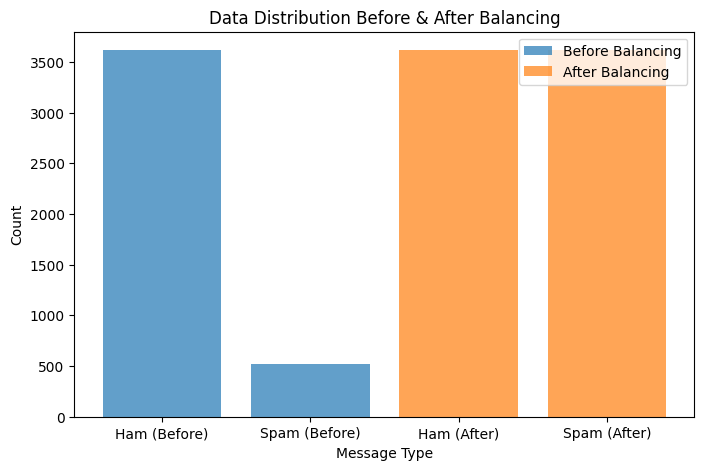

Test data saved as 'balanced_train.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:

after_balancing_counts = balanced_train['label'].value_counts()


print("Data distribution before balancing:")
print(before_balancing_counts)

print("\nData distribution after balancing:")
print(after_balancing_counts)

plt.figure(figsize=(8, 5))
plt.bar(['Ham (Before)', 'Spam (Before)'], before_balancing_counts, label="Before Balancing", alpha=0.7)
plt.bar(['Ham (After)', 'Spam (After)'], after_balancing_counts, label="After Balancing", alpha=0.7)
plt.xlabel("Message Type")
plt.ylabel("Count")
plt.title("Data Distribution Before & After Balancing")
plt.legend()
plt.show()

balanced_train.to_csv('balanced_train.csv', index=False)
print("Test data saved as 'balanced_train.csv'")


from google.colab import files
files.download('balanced_train.csv')



In [15]:
#Tokenization with DistilRoBERTa and BERT
tokenizer_distilroberta = RobertaTokenizer.from_pretrained('distilroberta-base')
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

train_tokens_distilroberta = tokenizer_distilroberta(list(balanced_train['message']), max_length=128, padding=True, truncation=True, return_tensors='pt')
valid_tokens_distilroberta = tokenizer_distilroberta(list(valid_texts), max_length=128, padding=True, truncation=True, return_tensors='pt')
test_tokens_distilroberta = tokenizer_distilroberta(list(test_texts), max_length=128, padding=True, truncation=True, return_tensors='pt')

train_tokens_bert = tokenizer_bert(list(balanced_train['message']), max_length=128, padding=True, truncation=True, return_tensors='pt')
valid_tokens_bert = tokenizer_bert(list(valid_texts), max_length=128, padding=True, truncation=True, return_tensors='pt')
test_tokens_bert = tokenizer_bert(list(test_texts), max_length=128, padding=True, truncation=True, return_tensors='pt')

train_labels = torch.tensor(balanced_train['label'].values, dtype=torch.long)
valid_labels = torch.tensor(valid_labels.values, dtype=torch.long)
test_labels = torch.tensor(test_labels.values, dtype=torch.long)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
#PyTorch Dataset class

#Dataset and DataLoaders
class SpamDataset(Dataset):
    def __init__(self, tokens, labels):
        self.tokens = tokens
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.tokens['input_ids'][idx],
            'attention_mask': self.tokens['attention_mask'][idx],
            'label': self.labels[idx]
        }
from transformers import RobertaTokenizer

train_dataset_distilroberta = SpamDataset(train_tokens_distilroberta, train_labels)
valid_dataset_distilroberta = SpamDataset(valid_tokens_distilroberta, valid_labels)
test_dataset_distilroberta = SpamDataset(test_tokens_distilroberta, test_labels)

train_loader_distilroberta = DataLoader(train_dataset_distilroberta, batch_size=32, shuffle=True)
valid_loader_distilroberta = DataLoader(valid_dataset_distilroberta, batch_size=32)
test_loader_distilroberta = DataLoader(test_dataset_distilroberta, batch_size=32)

train_dataset_bert = SpamDataset(train_tokens_bert, train_labels)
valid_dataset_bert = SpamDataset(valid_tokens_bert, valid_labels)
test_dataset_bert = SpamDataset(test_tokens_bert, test_labels)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=32, shuffle=True)
valid_loader_bert = DataLoader(valid_dataset_bert, batch_size=32)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=32)

In [17]:
#hybrid model

class HybridModel(nn.Module):
    def __init__(self, model, mode):
        super(HybridModel, self).__init__()
        self.model = model
        self.mode = mode
        self.cnn = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(64 * 2, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.permute(0, 2, 1)

        if self.mode == "cnn_lstm":
            x = self.cnn(x)
            x = nn.ReLU()(x)
            x = x.permute(0, 2, 1)
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x).squeeze(-1)

In [18]:
#Model Initialization "DistilRoBERTa and BERT"

roberta_model = RobertaModel.from_pretrained('distilroberta-base')
bert_model = BertModel.from_pretrained('bert-base-uncased')

cnn_lstm_model_distilroberta = HybridModel(roberta_model, mode="cnn_lstm")
cnn_lstm_model_bert = HybridModel(bert_model, mode="cnn_lstm")

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [19]:
#Training and Evaluation Functions

def train_model(model, dataloader, optimizer, criterion, device, val_loader=None):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).float()

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if val_loader:
        val_metrics = evaluate_model(model, val_loader, device)
        print(f"Validation Metrics - Accuracy: {val_metrics['accuracy']:.4f}, Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, F1-Score: {val_metrics['f1']:.4f}")

    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions) > 0.5
    return {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions),
        'recall': recall_score(true_labels, predictions),
        'f1': f1_score(true_labels, predictions),
        'predictions': predictions,
        'true_labels': true_labels
    }

def plot_confusion_matrix(true_labels, pred_labels, title):
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_roc_curve(true_labels, pred_probs, title):
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [ ]:
#Move Models to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_lstm_model_distilroberta.to(device)
cnn_lstm_model_bert.to(device)


HybridModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
#Optimizers for each model
optimizer_cnn_lstm_distilroberta = torch.optim.AdamW(cnn_lstm_model_distilroberta.parameters(), lr=1e-5)
optimizer_cnn_lstm_bert = torch.optim.AdamW(cnn_lstm_model_bert.parameters(), lr=1e-5)

In [ ]:
#Loss function
criterion = nn.BCELoss()

In [ ]:
#Train and evaluate CNN-LSTM with DistilRoBERTa

for epoch in range(10):
    loss = train_model(cnn_lstm_model_distilroberta, train_loader_distilroberta, optimizer_cnn_lstm_distilroberta, criterion, device, val_loader=valid_loader_distilroberta)
    print(f"Epoch {epoch + 1}, CNN-LSTM Loss (DistilRoBERTa): {loss:.4f}")

# Evaluate the model
results_cnn_lstm_distilroberta = evaluate_model(cnn_lstm_model_distilroberta, test_loader_distilroberta, device)

# Print metrics
print("Evaluation Metrics for CNN-LSTM (DistilRoBERTa):")
print(f"Accuracy: {results_cnn_lstm_distilroberta['accuracy']:.4f}")
print(f"Precision: {results_cnn_lstm_distilroberta['precision']:.4f}")
print(f"Recall: {results_cnn_lstm_distilroberta['recall']:.4f}")
print(f"F1-Score: {results_cnn_lstm_distilroberta['f1']:.4f}")

# Plot Confusion Matrix
plot_confusion_matrix(
    results_cnn_lstm_distilroberta['true_labels'],
    results_cnn_lstm_distilroberta['predictions'],
    title="Confusion Matrix - DistilRoBERTa"
)

# Plot ROC Curve
plot_roc_curve(
    results_cnn_lstm_distilroberta['true_labels'],
    results_cnn_lstm_distilroberta['predictions'],
    title="ROC Curve - DistilRoBERTa"
)


In [ ]:
#Train and evaluate CNN-LSTM with BERT
for epoch in range(10):
    loss = train_model(cnn_lstm_model_bert, train_loader_bert, optimizer_cnn_lstm_bert, criterion, device, val_loader=valid_loader_bert)
    print(f"Epoch {epoch + 1}, CNN-LSTM Loss (BERT): {loss:.4f}")

# Evaluate the model
results_cnn_lstm_bert = evaluate_model(cnn_lstm_model_bert, test_loader_bert, device)

# Print metrics
print("Evaluation Metrics for CNN-LSTM (BERT):")
print(f"Accuracy: {results_cnn_lstm_bert['accuracy']:.4f}")
print(f"Precision: {results_cnn_lstm_bert['precision']:.4f}")
print(f"Recall: {results_cnn_lstm_bert['recall']:.4f}")
print(f"F1-Score: {results_cnn_lstm_bert['f1']:.4f}")

# Plot Confusion Matrix
plot_confusion_matrix(
    results_cnn_lstm_bert['true_labels'],
    results_cnn_lstm_bert['predictions'],
    title="Confusion Matrix - BERT"
)

# Plot ROC Curve
plot_roc_curve(
    results_cnn_lstm_bert['true_labels'],
    results_cnn_lstm_bert['predictions'],
    title="ROC Curve - BERT"
)


In [ ]:
# Collect results for comparison

comparison_data = {
    "Model": ["CNN-LSTM (DistilRoBERTa)", "CNN-LSTM (BERT)"],
    "Accuracy": [
        results_cnn_lstm_distilroberta['accuracy'],
        results_cnn_lstm_bert['accuracy']
    ],
    "Precision": [
        results_cnn_lstm_distilroberta['precision'],
        results_cnn_lstm_bert['precision']
    ],
    "Recall": [
        results_cnn_lstm_distilroberta['recall'],
        results_cnn_lstm_bert['recall']
    ],
    "F1-Score": [
        results_cnn_lstm_distilroberta['f1'],
        results_cnn_lstm_bert['f1']
    ]
}


In [ ]:
import pandas as pd

# Convert comparison data into a DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Display the DataFrame
print(df_comparison)


In [ ]:
import matplotlib.pyplot as plt

# Extract data for plotting
models = comparison_data["Model"]
accuracy = comparison_data["Accuracy"]
precision = comparison_data["Precision"]
recall = comparison_data["Recall"]
f1_score = comparison_data["F1-Score"]

# Custom pastel colors
colors = ['#AEDFF7', '#FFC085', '#B9E8C9', '#F7B5B3']  # Light Blue, Light Orange, Light Green, Light Red

# Plot bar chart
x = range(len(models))
plt.bar(x, accuracy, width=0.2, label='Accuracy', align='center', color=colors[0])
plt.bar([p + 0.2 for p in x], precision, width=0.2, label='Precision', align='center', color=colors[1])
plt.bar([p + 0.4 for p in x], recall, width=0.2, label='Recall', align='center', color=colors[2])
plt.bar([p + 0.6 for p in x], f1_score, width=0.2, label='F1-Score', align='center', color=colors[3])

# Configure plot
plt.xticks([p + 0.3 for p in x], models, rotation=15, fontsize=10, color='black')
plt.ylabel("Scores", fontsize=12)
plt.title("Model Comparison", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Lighter grid
plt.tight_layout()
plt.show()


In [ ]:
# ROC Curve for DistilRoBERTa
fpr1, tpr1, _ = roc_curve(results_cnn_lstm_distilroberta['true_labels'], results_cnn_lstm_distilroberta['predictions'])
roc_auc1 = auc(fpr1, tpr1)

# ROC Curve for BERT
fpr2, tpr2, _ = roc_curve(results_cnn_lstm_bert['true_labels'], results_cnn_lstm_bert['predictions'])
roc_auc2 = auc(fpr2, tpr2)

# Plot both ROC curves
plt.figure()
plt.plot(fpr1, tpr1, label=f"DistilRoBERTa (AUC = {roc_auc1:.2f})")
plt.plot(fpr2, tpr2, label=f"BERT (AUC = {roc_auc2:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
torch.save(cnn_lstm_model_bert.state_dict(), "cnn_lstm_model_bert.pth")
print("Model saved successfully!")


In [ ]:

cnn_lstm_model_bert.load_state_dict(torch.load("cnn_lstm_model_bert.pth"))
cnn_lstm_model_bert.eval()
print("Model loaded successfully!")


In [ ]:
sample_messages = [
    ("thanks for your ringtone order, reference t91. you will be charged gbp 4 per week. you can unsubscribe at anytime by calling customer services on 09057039994", 1),  # Spam
    ("dude avatar 3d was imp. at one point i thought there were actually flies in the room and almost tried hittng one as a reflex", 0),  # Ham
    ("email alertfrom: jeri stewartsize: 2kbsubject: low-cost prescripiton drvgsto listen to email call 123", 1), # Spam
    ("not yet had..ya sapna aunty manege y'day hogidhe..chinnu full weak and swalpa black agidhane..", 1)  # Ham
]


In [ ]:
from transformers import BertTokenizer
import torch
import numpy as np

def test_cnn_lstm_model(model, tokenizer, sample_messages, device):
    """
    Function to test the CNN-LSTM model (BERT) on sample messages.
    Args:
        model: The trained CNN-LSTM model.
        tokenizer: The tokenizer for BERT preprocessing.
        sample_messages: List of tuples (message, true_label).
                         true_label: 1 (spam), 0 (not spam)
        device: The device to run the model on ('cpu' or 'cuda').
    """
    model.eval()
    correct_predictions = 0
    total_samples = len(sample_messages)

    for message, true_label in sample_messages:

        inputs = tokenizer(
            message,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        )


        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)


        with torch.no_grad():
            output = model(input_ids, attention_mask)
            predicted_label = int((output > 0.5).cpu().numpy())

        print(f"Message: {message}")
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")

        if predicted_label == true_label:
            correct_predictions += 1


    accuracy = correct_predictions / total_samples
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")


In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


test_cnn_lstm_model(cnn_lstm_model_bert, tokenizer, sample_messages, device)


In [ ]:
#Move Models to Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cnn_lstm_model_distilroberta.to(device)
cnn_lstm_model_bert.to(device)


In [ ]:
torch.save(cnn_lstm_model_bert.state_dict(), "cnn_lstm_model_bert.pth")
print("Model saved successfully!")


In [ ]:
import os


print("Current Directory:", os.getcwd())
print("Files in Directory:", os.listdir())


In [ ]:
from google.colab import files
files.download("/content/cnn_lstm_model_bert.pth")


In [ ]:
from google.colab import files
files.download("/content/cnn_lstm_model_bert.pth")


In [ ]:
from google.colab import files
import shutil


shutil.copy("/content/cnn_lstm_model_bert.pth", "/content/mymodel.pth")


files.download("/content/mymodel.pth")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


!cp /content/cnn_lstm_model_bert.pth /content/drive/MyDrive/
